In [13]:
#Matar Ludovic

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from Simulator8085simCli.compiler import compile_program
from Simulator8085simCli.execute_ import execute
from tqdm import tqdm

* Dans le fichier *compiler.py*, la fonction *compile*_*program(program:str)->list* prend convertit une suite d'instructions LHLD, SHLD NOP en caractères hexadécimaux. Je modifie cette fonction pour qu'elle renvoie un objet de type string $compile$_$program(program:str)->str$: <br>
Ex:
SHLD 2024
NOP
LHLD 2024
SHLD 2024
NOP
LHLD 2024
$\longrightarrow$
22
24
20
0
22
25
20
0
2a
24
20
76 <br>


* Le fichier $execute.py$ exécute ensuite le fichier compilé obtenu en caractères hexadécimaux avec le programme écrit dans une boucle while. C'est grace à ce fichier que je peux extraire des signatures comportementales, telles que le temps d'exécution, le temps de latence et le compteur interne.
* Le fichier execute_.py est une modification de $execute.py$. Avec la fonction time.time,
    1. Je calcule le temps d'execution $full$_$time$ de la boucle while correspondant au code pour exécuter le fichier compilé.
    2. Je calcule aussi le temps culumé $latence$ passé dans les conditions $if, elif$ et $else$.
    3. En plus de renvoyer ces deux valeurs, j'ajoute le nombre d'itérations de la boucle while $iteration$_$count$. <br>

    
J'obtiens donc un espace de signatures à 3 dimensions. De plus, j'ai remplacé les instructions $sys.exit()$ par $break$. Enfin, j'ai remplacé l'entièreté du code dans $execute.py$ par la fonction $execute$ prenant en argument le programme compilé et renvoyant $full$_$time$,  $latence$  et $iteration$_$count$. 

Avec le code ci-dessous, je crée aléatoirement un programme contenant les instructions "NOP","LHLD", "SHLD"

In [5]:
def make_random_source_code(N = 100):
    instructions= ["NOP","LHLD", "SHLD"]
    list_instruction = np.random.randint(0,len(instructions), (N,))
    program = [instructions[ch] for ch in list_instruction]
    program =""
    for ch in list_instruction:
        program+= instructions[ch]
        if ch:
            arg = ""
            for i in range(2):
                rand = np.random.randint(0,255)
                arg+=(rand<16)*"0" +hex(rand).split("0x")[1]
            program+=" "+ arg
        program+="\n"
    program+="HLT"
    return program

Exemple de sortie donnée par cette fonction pour N=4 instructions:

In [6]:
out = make_random_source_code(N = 4)
print(out)

SHLD d627
LHLD 0a70
SHLD c273
NOP
HLT


# Implémentation du Buffer

J'implémente la classe Buffer qui permet de garder en mémoire des couples $(code, signatures)$. 
Elle est munie des attribus:
* $self.code$_$list$. list. Contient des programmes écrits comme des variables de type str comme ci-dessous.
* $self.signature$_$list$. Contient les signatures de type $dict$ que l'on ajoute en appellant la méthode $store$
* $self.iterationcountarray$_$min $
* $self.iterationcount$_$array$_$max$ 
* $self.full$_$timearray$_$min$
* $self.full$_$timearray$_$max$
* $self.latencearray$_$min$
* $self.latencearray$_$max$
  
Elle est munie des méthodes:

* $store(code:str, signature:dict)$ qui ajoute le code et la signature aux listes attribues $self.code$_$list$ et $self.signature$_$list$
* $signature$_$at$_$random()->dict$ échantillone un point dans l'espace des signatures, ici définit comme un espace à trois dimensions, le temps d'exécution, le temps de latence, et le nombre d'iterations dans la boucle.
* $select$_$closest$_$code(self,signature: dict)->dict$: La méthode choisie la signature apparetenant au buffer qui minimise sa distance quadratique avec la signature en argument.
* $__init__(n:int,max_instructions:int)$. Avec $n$ le nombre de programmes pour initialiser le buffer, et $max$_$instructions$ qui correspond au nombre maximum d'instructions dans les programmes. Choisir n grand permet d'obtenir des minima et maxima bien représentatifs, et assure de tirer aléatoirement des signatures cohérentes.

In [7]:
class Buffer:
    def __init__(self,n:int,max_instructions:int):
        """
        code_list: list. Contains programs writtens as str
        signature_list: list. Contains signatures of the corresponding program execution, of type dict
        idx_list: list. Contains the indices for the corresponding code and signature
        n: int. number of couple(s) (code, signature) to init the buffer with
        max_instructions: int. Maximum number of instructions for the initialization programs
        """
        self.code_list = []
        self.signature_list = []
        self.idx_list = []
        self.iteration_count_array_min = 1000
        self.iteration_count_array_max = 0
        self.full_time_array_min = 1000
        self.full_time_array_max = 0
        self.latence_array_min = 1000
        self.latence_array_max = 0
        for i in range(n):
            program = make_random_source_code(10)
            compiled = compile_program(program)
            self.store(program,execute(compiled))
    def store(self,code:str, signature:dict):
        self.code_list.append(code)
        self.signature_list.append(signature)
        if signature["iteration_count"]<self.iteration_count_array_min:
            self.iteration_count_array_min = signature["iteration_count"]
        if signature["iteration_count"]>self.iteration_count_array_max:
            self.iteration_count_array_max = signature["iteration_count"]
        if signature["full_time"]<self.full_time_array_min:
            self.full_time_array_min = signature["full_time"]
        if signature["full_time"]>self.full_time_array_max:
            self.full_time_array_max = signature["full_time"]
        if signature["latence"]<self.latence_array_min:
            self.latence_array_min = signature["latence"]
        if signature["latence"]>self.latence_array_max:
            self.latence_array_max = signature["latence"]
    def select_closest_code(self,signature: dict)->dict:
        min_distance = 0
        idx = 0
        for j,signature_buffer in enumerate(self.signature_list):
            dist = 0
            for k in signature_buffer.keys():
                dist += (signature_buffer[k] - signature[k])**2
            if dist<min_distance:
                min_distance= dist
                idx = j
        return {"code": self.code_list[idx] ,"signature": self.signature_list[idx]}
    def signature_at_random(self)->dict:
        return {"latence":np.random.uniform(self.latence_array_min, self.latence_array_max, (1,)),
         "full_time": np.random.uniform(self.full_time_array_min, self.full_time_array_max, (1,)),
         "iteration_count": np.random.randint(self.iteration_count_array_min, self.iteration_count_array_max+1, (1,))}

# On ecrit le code de mutation

Je choisis de modifier le code avant compilation pour m'assurer de rester dans le cadre limité aux instructions LHLD, SHLD et NOP.

In [8]:
def code_mutation(program:str):
    """
    program: str. LHLD, SHLD and  NOP instructions
    """
    instructions= ["NOP","LHLD", "SHLD"]
    program_split = program.split("\n")
    istr = np.random.randint(0,len(instructions), (1,)).item()
    arg = ""
    if istr:
        for i in range(2):
            rand = np.random.randint(0,255)
            arg+=(rand<16)*"0"+ hex(rand).split("0x")[1]
    idx = np.random.randint(0,len(program_split)-1,(1,)).item()
    program_split[idx] = instructions[istr] + " " + arg
    program = ""
    for ch in program_split:
        program+=ch+"\n"
    return program

Je modifie aléatoiremenent l'instruction écrite à une ligne selectionée aléatoirement. J'ajoute argument choisi alétoirement si l'instruction selectionée est LHLD ou SHLD. Exemple de mutation de code:

In [9]:
print(out)
print("==>")
print(code_mutation(out))

SHLD d627
LHLD 0a70
SHLD c273
NOP
HLT
==>
SHLD d627
LHLD 0a70
NOP 
NOP
HLT



# Pseudocode IMGEP simplifié

J'implémente la boucle décrite dans l'excercice qui a pour objectif d’explorer l’espace de codes afin de découvrir
une diversité de signatures comportementales possibles

In [10]:
N = 1000
buffer = Buffer(1000,100)
signature_array = np.array(buffer.signature_list)
for j in tqdm(range(N)):
    random_signature = buffer.signature_at_random()
    out = buffer.select_closest_code(random_signature)
    program = out["code"]
    mutated_program= code_mutation(program)
    assert mutated_program!=program
    compiled = compile_program(mutated_program)
    buffer.store(program,execute(compiled))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 102.95it/s]


# Discussion résultats

Sur les plots présentés ci-dessous, on lit les valeurs des temps d'exécution et des temps de latences et fonction des indices dans le buffer. Les mille premières valeurs permettent d'initialiser le buffer, et donc de calculer les valeurs min et max l'échantillonnage. Les valeurs suivantes sont celles obtenues pendant la boucle d'exploration. J'observe ensuite un changement brutal des amplitudes pour les signatures, et les valeurs se stabilisent autour d'une valeur moyenne. Je pense qu'il s'agit d'un inconvénient notable de l'algorithme présenté: c'est à dire sa capacité à s'enfermer dans une tendance. La boucle d'exploration 3.1 dans la thèse de M. Etcheverry semble davatange efficace pour ne pas tomber dans de telles tendances, en raison de la politique d'exploration introduite, qui est mise à jour, avec l'espace des objectifs.

In [11]:
print("iteration count min",buffer.iteration_count_array_min,"\n",
      "iteration count max",buffer.iteration_count_array_max,"\n",
      "full time min", buffer.full_time_array_min,"\n",
      "full time max", buffer.full_time_array_max,"\n",
      "latence min",buffer.latence_array_min,"\n",
      "latence max", buffer.latence_array_max)

iteration count min 1 
 iteration count max 12 
 full time min 2.09808349609375e-05 
 full time max 0.0002357959747314453 
 latence min 4.76837158203125e-07 
 latence max 1.52587890625e-05


In [12]:
full_time = [v["full_time"] for v in buffer.signature_list]
latence = [v["latence"] for v in buffer.signature_list]

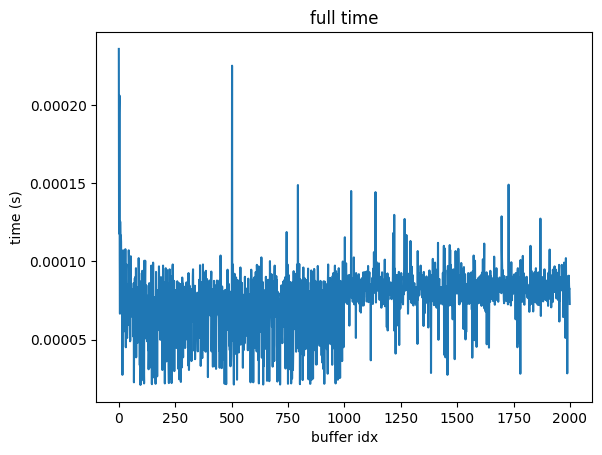

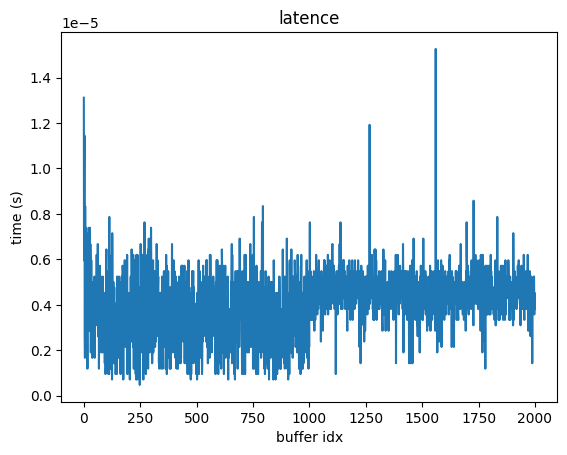

In [13]:
plt.plot(full_time)
plt.title("full time")
plt.xlabel("buffer idx")
plt.ylabel("time (s)")
plt.show()
plt.plot(latence)
plt.title("latence")
plt.xlabel("buffer idx")
plt.ylabel("time (s)")
plt.show()